# Capacitor de Placas Concéntricas Elípticas

En el capacitor, la placa exterior se encuentra a un potencial eléctrico $V_{ext}(\nu)$, mientras que la placa interior se encuentra a un potencial $V_{int}(\nu)$. El problema de valores en la frontera descrito en coordenadas elípticas se define:

$$\frac{1}{\sinh^2(\mu)+\sin^2(\nu)} (\frac{\partial^2V}{\partial\mu^2} + \frac{\partial^2V}{\partial\nu^2}) = 0,    \forall(\mu,\nu) \in \Omega$$

$$V(0.1, \nu) = \sin(2\nu), \forall\nu\in[0, 2\pi]$$
$$V(1, \nu) = 0, \forall\nu\in[0, 2\pi]$$

donde $\Omega$ es el dominio acotado por $\mu \in [0.1, 1] \times \nu \in [0, 2\pi]$.

In [1]:
import numpy as np
import sympy as sp
from sympy import init_printing, Eq
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import numpy.linalg as la
import matplotlib.pyplot as plt
from types import LambdaType

init_printing()

In [2]:
Vij, Vi1j, Vij1, Vim1j, Vijm1, du, dv = sp.symbols(r'V_{i\,j} V_{i+1\,j} V_{i\,j+1} V_{i-1\,j} V_{i\,j-1} \triangle\mu \triangle\nu')
u, v = sp.symbols(r'\mu \nu')
Vij, Vi1j, Vij1, Vim1j, Vijm1, du, dv, u, v

(V_{i,j}, V_{i+1,j}, V_{i,j+1}, V_{i-1,j}, V_{i,j-1}, \triangle\mu, \triangle\
nu, \mu, \nu)

### Escribamos el esquema de diferencias finitas

In [3]:
laplacian = (((Vi1j - 2*Vij + Vim1j)/du**2) + ((Vij1 - 2*Vij + Vijm1)/dv**2))
sys = Eq(laplacian, 0)
sp.simplify(sys)

            2                                                   2             
\triangle\mu ⋅(V_{i,j+1} + V_{i,j-1} - 2⋅V_{i,j}) + \triangle\nu ⋅(V_{i+1,j} -
──────────────────────────────────────────────────────────────────────────────
                                                 2             2              
                                     \triangle\mu ⋅\triangle\nu               

                           
 2⋅V_{i,j} + V_{i-1,j})    
─────────────────────── = 0
                           
                           

Véase que el termino senosoidal nunca es 0, luego basta con verificar que el término diferencial es 0

Finalmente si nombramos $$\frac{(\triangle\mu)^2}{(\triangle\nu)^2} = \alpha$$

In [4]:
alpha = sp.Symbol(r'\alpha')
rhs = Vi1j - 2*Vij + Vim1j + (Vij1 - 2*Vij + Vijm1)*alpha
new_eq = sp.Eq(rhs, 0)
new_eq

V_{i+1,j} - 2⋅V_{i,j} + V_{i-1,j} + \alpha⋅(V_{i,j+1} + V_{i,j-1} - 2⋅V_{i,j})
 = 0

El cual puede ser escrito como:

In [5]:
rhs = -2*(1+alpha)*Vij + Vi1j + Vim1j + alpha*Vij1 + alpha*Vijm1
final_eq = Eq(rhs, 0)
final_eq

V_{i+1,j} + V_{i,j+1}⋅\alpha + V_{i,j-1}⋅\alpha + V_{i,j}⋅(-2⋅\alpha - 2) + V_
{i-1,j} = 0

Ahora con nuestro esquema de diferencias finitas listas y las condiciones de frontera armemos nuestro sistema global teniendo en cuenta además que si $j=0$:
$$V_{i, j-1} = V_{i, j_{max}}$$
y si $j=j_{max}$:
$$V_{i, j_{max}+1} = V_{i, 0}$$

## Solución del Potencial Eléctrico

In [6]:
def electric_potential(n_u1, n_u2, v_ext, v_int):

    # Lambdify boundary conditions (To allow for both function and int dirichlet conditions)
    v = sp.symbols(r'\nu')
    if isinstance(v_ext, LambdaType) == False:
      v_ext = sp.lambdify(v, v_ext)

    if isinstance(v_int, LambdaType) == False:
      v_int = sp.lambdify(v, v_int)


    # Divide the domain acording to n_u1 and n_u2
    mu = np.linspace(0.1, 1, n_u1 )
    nu = np.linspace(0, 2*np.pi, n_u2 + 1) #To avoid having 2 nodes in 0 = 2pi

    # Calc differentials and constant
    dmu = mu[1] - mu[0]
    dnu = nu[1] - nu[0]
    alpha = (dmu**2)/(dnu**2)

    # Prepare parameters for the global system
    tg = lambda i, j: i*(n_u2) + j # To global system
    dim = n_u1 * n_u2 # dimensions of the global matrix A(dim, dim)

    # Initialize sparse (lil) matrix lil is used because it´s fast to update
    A = lil_matrix((dim, dim))
    b = lil_matrix((dim, 1))

    ij = np.zeros((dim, 2))

    j_max = n_u2 - 1


    for k in range(dim):
        # First let's identify i, j in the global system
        i = k//n_u2
        j = k - (k//n_u2)*n_u2
        ij[k, 0] = i
        ij[k, 1] = j


        ### Boundary conditions
        if(i == 0): # Internal condition
            A[k, k] = 1
            b[k, :] = v_int(nu[j])
        elif(i == n_u1 - 1): # External condition
            A[k, k] = 1
            b[k, :] = v_ext(nu[j])
        else: # General case
            A[k, k] = -2*(1+alpha)
            A[k, tg(i+1, j)] = 1
            A[k, tg(i-1, j)] = 1

            # Special cases for j
            if(j == j_max):
                A[k, tg(i, 0)] = alpha
            else:
                A[k, tg(i, j+1)] = alpha

            if(j == 0):
                A[k, tg(i, j_max)] = alpha
            else:
                A[k, tg(i, j-1)] = alpha

    # Calculate the potential
    # We cast to csr_matrix for optimal calculation time with large A matrices
    potential = spsolve(csr_matrix(A), csr_matrix(b))
    potential = potential.reshape(-1, 1)

    return np.hstack((ij, potential))

## Solución Campo Eléctrico

De electromagnetismo conocemos que para calcular el campo eléctrico podemos uilizar la expresión:
$$\vec{E} = -\nabla V$$
Es decir:
$$\vec{E} = -\frac{1}{c \sqrt{\sinh^2{\mu} + \sin^2{\nu}}}(\frac{\partial V}{\partial \mu}, \frac{\partial V}{\partial \nu})$$
Como ya conocemos el potencial eléctrico en todos los lugares del espacio podemos solucionar con un esquema de diferencias finitas con la siguiente regla de formación:
$$i = 0 \Rightarrow \frac{\partial V}{\partial \mu} = \frac{V_{i+1,j} - V_{i,j}}{\triangle\mu}$$
$$i = i_{max} \Rightarrow \frac{\partial V}{\partial \mu} = \frac{V_{i,j} - V_{i-1,j}}{\triangle\mu}$$
$$i \neq 0 \land i \neq i_{max} \Rightarrow \frac{\partial V}{\partial \mu} = \frac{V_{i+1,j} - V_{i-1,j}}{2\triangle\mu}$$
$$\forall j \in [0, j_{max}] \Rightarrow \frac{\partial V}{\partial \nu} = \frac{V_{i,j + 1} - V_{i,j - 1}}{2\triangle\nu}$$
Teniendo en cuenta que si $j=0$:
$$V_{i, j-1} = V_{i, j_{max}}$$
y si $j=j_{max}$:
$$V_{i, j_{max}+1} = V_{i, 0}$$

In [7]:
def electric_field(n_u1, n_u2, e_potential):
    # Divide the domain acording to n_u1 and n_u2
    mu = np.linspace(0.1, 1, n_u1)
    nu = np.linspace(0, 2*np.pi, n_u2 + 1 )
    dmu = mu[1] - mu[0]
    dnu = nu[1] - nu[0]

    # Prepare all relevant variables and arrays before looping
    dim = n_u1 * n_u2
    e_field = np.zeros((dim, 4))
    e_field[:, 0:2] = e_potential[:, 0:2]
    tg = lambda i, j: i*(n_u2) + j # To global
    i_max = n_u1 - 1
    j_max = n_u2 - 1
    V = e_potential[:, 2]
    c = 1

    # Apply finite differences with the conditions mentioned above
    # Notice we work directly in the gloabl system
    for k in range(dim):
        i = int(e_potential[k, 0])
        j = int(e_potential[k, 1])

        sf = -1 / (c*np.sqrt(np.sinh(mu[i])**2+np.sin(nu[j])**2))

        if(i==0):
            e_field[k, 2] = ((V[tg(i+1, j)] - V[tg(i, j)])/dmu) * sf
        elif(i == i_max):
            e_field[k, 2] = ((V[tg(i, j)] - V[tg(i-1, j)])/dmu) * sf
        else:
            e_field[k, 2] = ((V[tg(i+1, j)] - V[tg(i-1, j)])/(2*dmu)) * sf


        if(j==0):
            e_field[k, 3] = ((V[tg(i, j+1)] - V[tg(i, j_max)])/(2*dnu)) * sf
        elif(j==j_max):
            e_field[k, 3] = ((V[tg(i, 0)] - V[tg(i, j-1)])/(2*dnu)) * sf
        else:
            e_field[k, 3] = ((V[tg(i, j+1)] - V[tg(i, j-1)])/(2*dnu)) * sf


    return e_field

Recordando las transformaciones de coordenadas elípticas a coordenadas cartesianas:
$$x = c \cosh(\mu)\cos(\nu)$$
$$y = c \sinh(\mu)\sin(\nu)$$

In [8]:
def plot_electric_solution(n_u1, n_u2, potential_V, efield_E):
    # Divide the domain acording to n_u1 and n_u2
    mu = np.linspace(0.1, 1, n_u1)
    nu = np.linspace(0, 2 * np.pi, n_u2 + 1)

    # Focal point of the elipses
    c = 1

    # Relevant parameters
    jmax = len(nu) - 1

    # Empty 2D arrays for coordinates and values of both V and E
    # We will manually fill them instead of using meshgrid to avoid confusion
    X = np.zeros((n_u1, n_u2 + 1))
    Y = np.zeros((n_u1, n_u2 + 1))
    V = np.zeros((n_u1, n_u2 + 1))
    E = np.zeros((n_u1, n_u2 + 1))


    for i, j, V_k in potential_V:
        i = int(i)
        j = int(j)

        # Perform the variable change
        x = c*np.cosh(mu[i]) * np.cos(nu[j])
        y = c*np.sinh(mu[i]) * np.sin(nu[j])

        # Fill the 2D arrays
        X[i, j] = x
        Y[i, j] = y
        V[i, j] = V_k

        # Take into account the edge case for the missing node in 2pi
        if ((j + 1) == jmax):
            x = c*np.cosh(mu[i]) * np.cos(nu[jmax])
            y = c*np.sinh(mu[i]) * np.sin(nu[jmax])
            X[i, jmax] = x
            Y[i, jmax] = y
            V[i, jmax] = V[i, 0]

    for i, j, E_mu, E_nu in efield_E:
        i = int(i)
        j = int(j)

        # Calc magnitude of E_field
        E[i, j] = np.sqrt(E_mu**2 + E_nu**2)

        # Take the edge case into account again
        if ((j + 1) == jmax):
            E[i, jmax] = E[i, 0]


    # Plotting
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    cp1 = ax1.contourf(X, Y, V, 100, cmap="viridis")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.title.set_text('Potencial eléctrico en coordenadas elípticas')

    cp2 = ax2.contourf(X, Y, E, 100, cmap="viridis")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.title.set_text('Magnitud del campo eléctrico en coordenadas elípticas')

    fig.colorbar(cp1, label='Potencial Eléctrico (V)')
    fig.colorbar(cp2, label='Norma del Campo Eléctrico (V/m)')
    fig.tight_layout()

    fig.show()

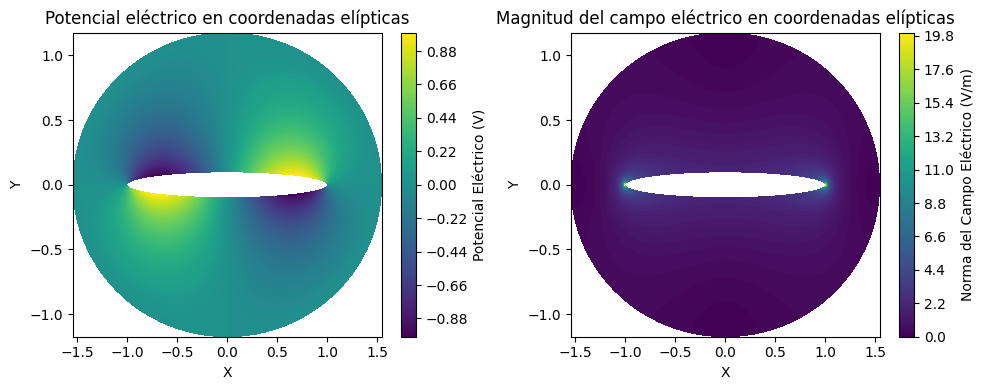

In [9]:
# Solución Internas

n_u = 100
n_v = 100
v_ext = 0
v_int = lambda v: np.sin(2*v) #np.sin(2*v)

e_potential = electric_potential(n_u, n_v, v_ext, v_int)
e_field = electric_field(n_u, n_v, e_potential)
plot_electric_solution(n_u, n_v, e_potential, e_field)


## Verifiquemos que el código funciona correctamente con algunas situaciones conocidas

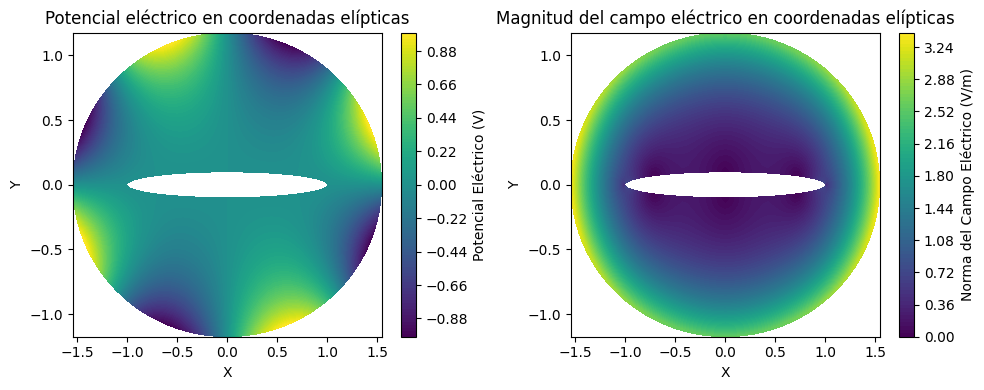

In [14]:
# Solución Externas
# Para verificar que todo funcione correctamente tomando como referencia
# la solución en polares.
n_u = 100
n_v = 100
v_ext = lambda v: np.sin(4*v)
v_int = 0 #np.sin(2*v)

e_potential = electric_potential(n_u, n_v, v_ext, v_int)
e_field = electric_field(n_u, n_v, e_potential)

plot_electric_solution(n_u, n_v, e_potential, e_field)

### Ahora evaluemos superficies equipotenciales


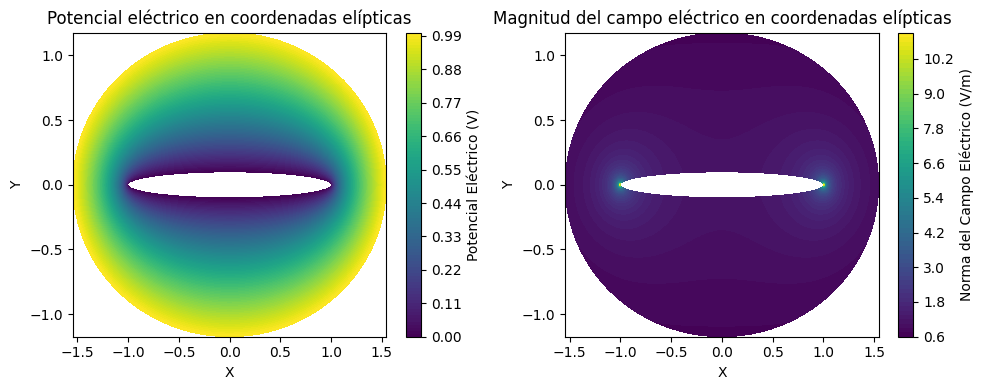

In [15]:

n_u = 100
n_v = 100
v_ext = 1
v_int = 0

e_potential = electric_potential(n_u, n_v, v_ext, v_int)
e_field = electric_field(n_u, n_v, e_potential)

plot_electric_solution(n_u, n_v, e_potential, e_field)